In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

tf.reset_default_graph()

In [2]:
def MinMaxScaler(data):
    
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  This is separate from the ipykernel package so we can avoid doing imports until


xy shape :  (41943, 4) y shape :  (41943, 1)
train_setx shape :  (29360, 4) train_sety shape :  (29360, 1)
test_setx shape :  (12593, 4) test_sety shape :  (12593, 1)
trainX shape :  (29350, 10, 4) trainY shape :  (29350, 1)
testX shape :  (12583, 10, 4) testY shape :  (12583, 1)
Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Y_pred shape :  (?, 1)
[step: 0] loss: 186099.078125
[step: 1] loss: 184170.6875
[step: 2] loss: 182166.3125
[step: 3] loss: 180009.484375
[step: 4] loss: 177611.46875
[step: 5] loss: 174847.171875
[step: 6] loss: 171527.25
[step: 7] loss: 167567.71875
[step: 8] loss: 163002.234375
[step: 9] loss: 157932.640625
[step: 10] loss: 152518.828125
[step: 11] loss: 147120.453125
[step: 12] loss: 142250.109375
[step: 13] loss: 138306.171875
[step: 14] loss: 135481.3125
[step: 15] loss: 1333

[step: 245] loss: 67927.2734375
[step: 246] loss: 67855.25
[step: 247] loss: 67787.8515625
[step: 248] loss: 67722.328125
[step: 249] loss: 67657.5625
[step: 250] loss: 67596.8359375
[step: 251] loss: 67561.671875
[step: 252] loss: 67641.2109375
[step: 253] loss: 67845.0
[step: 254] loss: 67370.34375
[step: 255] loss: 67614.53125
[step: 256] loss: 67440.1640625
[step: 257] loss: 67375.125
[step: 258] loss: 67362.671875
[step: 259] loss: 67182.078125
[step: 260] loss: 67267.7578125
[step: 261] loss: 67071.6015625
[step: 262] loss: 67189.6484375
[step: 263] loss: 66951.0546875
[step: 264] loss: 67074.1796875
[step: 265] loss: 66866.1796875
[step: 266] loss: 66967.7265625
[step: 267] loss: 66808.109375
[step: 268] loss: 66821.71875
[step: 269] loss: 66753.671875
[step: 270] loss: 66691.9453125
[step: 271] loss: 66698.6484375
[step: 272] loss: 66583.265625
[step: 273] loss: 66626.8828125
[step: 274] loss: 66508.4921875
[step: 275] loss: 66507.734375
[step: 276] loss: 66449.7578125
[step: 2

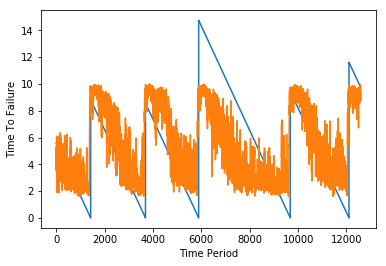

In [3]:
if "DISPLAY" not in os.environ:
    # remove Travis CI Error
    matplotlib.use('Agg')

# train Parameters
seq_length = 10
data_dim = 4
hidden_dim = 10
output_dim = 1
learning_rate = 0.005
iterations = 500

# Open, High, Low, Volume, Close
#xy = np.loadtxt('preprocessed/X_train_15K.csv', delimiter=',', usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13))
xy = np.loadtxt('preprocessed/X_train_15K.csv', delimiter=',', usecols=(0,1,2,3))
y = np.loadtxt('preprocessed/y_train_15K.csv', delimiter = ',')
y = np.reshape(y, (len(y),1))
#print(xy)
#print(y)
print("xy shape : ", xy.shape, "y shape : ",y.shape)

# train/test split
train_size = int(len(xy) * 0.7)
train_setx = xy[0:train_size]
train_sety = y[0:train_size]
test_setx = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence
test_sety = y[train_size - seq_length:]

# Scale each
# train_setx = MinMaxScaler(train_setx)
# train_sety = MinMaxScaler(train_sety)
# test_setx = MinMaxScaler(test_setx)
# test_sety = MinMaxScaler(test_sety)
print("train_setx shape : ", train_setx.shape, "train_sety shape : ", train_sety.shape)
print("test_setx shape : ", test_setx.shape, "test_sety shape : ", test_sety.shape)

# build datasets
def build_dataset(XX, YY, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(XX) - seq_length):
        _x = XX[i:i + seq_length, :]
        _y = YY[i+seq_length]

        #print("_x shape : ", _x.shape)
        #print("_y shape : ", _y.shape)
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_setx, train_sety, seq_length)
testX, testY = build_dataset(test_setx, test_sety, seq_length)
finalX, finalY = build_dataset(xy, y, seq_length)
# print("trainX")
# print(trainX)
# print("trainY")
# print(trainY)
# print("testX")
# print(testX)
# print("testY")
# print(testY)
print("trainX shape : ", trainX.shape, "trainY shape : ", trainY.shape)
print("testX shape : ", testX.shape, "testY shape : ", testY.shape)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output
print("Y_pred shape : ", Y_pred.shape)

# cost/loss
loss = tf.reduce_sum(tf.abs(Y_pred - Y))  # sum of the absolute values 이거 reduced_mean으로 바꿔봤는데 오차 증가함
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
rmae = tf.reduce_mean(tf.abs(targets - predictions))

sess = tf.Session() 
final_sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
final_sess.run(init)

# Training step
for i in range(iterations):
    _, step_loss = sess.run([train, loss], feed_dict={
                            X: trainX, Y: trainY})
    print("[step: {}] loss: {}".format(i, step_loss))
        
#     scores = cross_validate(reg_lin, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
#     print(scores['test_score'])
#     print("{:.4f}".format(sum(scores['test_score']) / 5))

# Test step
test_predict = sess.run(Y_pred, feed_dict={X: testX})
print("test_predict shape : ", test_predict.shape)
# rmse_val = sess.run(rmse, feed_dict={
#                 targets: testY, predictions: test_predict})
# print("RMSE: {}".format(rmse_val))

rmae_val = sess.run(rmae, feed_dict={
                targets: testY, predictions: test_predict})
print("RMAE: {}".format(rmae_val))


    
# Plot predictions
plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Time To Failure")
plt.show()


In [4]:
for i in range(iterations):
    _, step_loss = final_sess.run([train, loss], feed_dict={
                            X: finalX, Y: finalY})
    print("[step: {}] loss: {}".format(i, step_loss))

[step: 0] loss: 230533.4375
[step: 1] loss: 229733.328125
[step: 2] loss: 228961.734375
[step: 3] loss: 228194.5
[step: 4] loss: 227404.203125
[step: 5] loss: 226563.234375
[step: 6] loss: 225642.140625
[step: 7] loss: 224615.5625
[step: 8] loss: 223451.75
[step: 9] loss: 222114.171875
[step: 10] loss: 220559.296875
[step: 11] loss: 218739.328125
[step: 12] loss: 216609.71875
[step: 13] loss: 214151.484375
[step: 14] loss: 211419.15625
[step: 15] loss: 208588.671875
[step: 16] loss: 205887.46875
[step: 17] loss: 203399.21875
[step: 18] loss: 200967.546875
[step: 19] loss: 198379.515625
[step: 20] loss: 195466.0625
[step: 21] loss: 192126.125
[step: 22] loss: 188321.921875
[step: 23] loss: 184122.46875
[step: 24] loss: 179719.078125
[step: 25] loss: 175452.1875
[step: 26] loss: 171692.90625
[step: 27] loss: 168713.3125
[step: 28] loss: 166467.671875
[step: 29] loss: 164751.984375
[step: 30] loss: 163322.671875
[step: 31] loss: 162035.4375
[step: 32] loss: 160772.640625
[step: 33] loss: 

[step: 264] loss: 92806.5234375
[step: 265] loss: 92702.1328125
[step: 266] loss: 92713.078125
[step: 267] loss: 92662.4140625
[step: 268] loss: 92599.8359375
[step: 269] loss: 92604.9921875
[step: 270] loss: 92537.7109375
[step: 271] loss: 92510.0625
[step: 272] loss: 92499.4609375
[step: 273] loss: 92431.328125
[step: 274] loss: 92414.0546875
[step: 275] loss: 92392.96875
[step: 276] loss: 92332.25
[step: 277] loss: 92316.734375
[step: 278] loss: 92295.0
[step: 279] loss: 92239.703125
[step: 280] loss: 92220.984375
[step: 281] loss: 92203.8515625
[step: 282] loss: 92153.4453125
[step: 283] loss: 92123.7890625
[step: 284] loss: 92106.4453125
[step: 285] loss: 92071.625
[step: 286] loss: 92031.484375
[step: 287] loss: 92011.703125
[step: 288] loss: 91988.828125
[step: 289] loss: 91951.7734375
[step: 290] loss: 91919.6953125
[step: 291] loss: 91898.859375
[step: 292] loss: 91874.0390625
[step: 293] loss: 91841.5078125
[step: 294] loss: 91811.703125
[step: 295] loss: 91790.140625
[step: 

In [5]:
#s_t = time.time()

test_path = 'test'
test_list = os.listdir(test_path)
X_test = []
number_of_csvs = 2624
number_of_rows_in_each_csvs = 150000
divide_size = int(number_of_rows_in_each_csvs/seq_length)
print("divide_size : ", divide_size)


for path in test_list:
    test = pd.read_csv(os.path.join(test_path, path), dtype=np.float64)
    #print("test shape : ", test.shape)
    for i in range(0, seq_length):
        #test_divided_by_size = test[i*size:(i+1)*15000, :]
        test_divided_by_length = test[i*divide_size:(i+1)*divide_size]
        #print("test_divided_by_length shape : ", test_divided_by_length.shape)
        X_test.append(gen_features(test_divided_by_length).values)
    
X_test = np.array(X_test)
#X_test = X_test[:, [0,4,5,6,7,8,11,12]]
#X_test = X_test[:, [0,4,5,6,7,8,11,12]]
X_test = X_test[:, [0,1,2,3]]

print("X_test shape : ", X_test.shape) #maybe 2624*10 = 26240 (26240,13)
#print(X_test[0:1000, :])

def build_dataset_for_predict(XX, seq_length):
    dataX = []
    for i in range(0, number_of_csvs*seq_length,seq_length): # 0 ~ 26230
        _x = XX[i:i + seq_length, :]
        dataX.append(_x)
    return np.array(dataX)

X_test_final = build_dataset_for_predict(X_test, seq_length)
print("X_test_final shape : ", X_test_final.shape) # (26240, 10, 13)

#X_test = MinMaxScaler(X_test)
#scaler = StandardScaler().fit(X_test)
#X_test = scaler.transform(X_test)

predict = final_sess.run(Y_pred, feed_dict={X: X_test_final})
print("predict shape : ", predict.shape)

# reg = reg_grid.best_estimator_
# reg.fit(X_train, y_train)
# y_pred = reg.predict(X_test)
pd.DataFrame(predict).to_csv('20190325_prediction_LSTM_5.csv', header=None)

#e_t = time.time()
#duration = (e_t - s_t) / 60
#print("{:.1f} min tooked".format(duration))

divide_size :  15000
X_test shape :  (26240, 4)
X_test_final shape :  (2624, 10, 4)
predict shape :  (2624, 1)
